Misc imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
from six.moves.cPickle import load
import cPickle
import numpy as np

from snorkel import SnorkelSession
from snorkel.parser import XMLMultiDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser.corenlp import StanfordCoreNLPServer
from snorkel.models import Document, Sentence, Candidate, candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels, FeatureAnnotator, save_marginals, load_marginals
from snorkel.learning import SparseLogisticRegression, GenerativeModel, RandomSearch
from snorkel.learning.structure import DependencySelector
from snorkel.learning.utils import MentionScorer
# from snorkel.contrib.rnn import reRNN

import matchers
import LF
from candidate_adjective_fixer import *
from load_external_annotations_new import load_external_labels

session = SnorkelSession()

BiomarkerDrug = candidate_subclass('BiomarkerDrug', ['biomarker', 'drug'])



/Users/gmachiraju/py2_kernel/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Helper functions

In [2]:
#------------------
# Helper Functions
#------------------

def grabCandidates(extractor, schema):
    # Candidate Counts
    for k, sents in enumerate([train_sents, dev_sents, test_sents]):
        extractor.apply(sents, split=k, clear=False)
        print "Number of candidates: ", session.query(schema).filter(schema.split == k).count()
        session.commit()
        
    train_cands = session.query(schema).filter(
        schema.split == 0).all()
    dev_cands = session.query(schema).filter(
        schema.split == 1).all()
    test_cands = session.query(schema).filter(
        schema.split == 2).all()

    return [train_cands, dev_cands, test_cands]

In [3]:
#-----------------------
# Setup & Preprocessing
#-----------------------

# Instantiate the Session
session = SnorkelSession()

# Doc Preprocessing
file_path = 'articles/training.xml'
train_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//article',
    text='.//front/article-meta/abstract/p/text()',
    id='.//front/article-meta/article-id/text()'
)

file_path = 'articles/development.xml'
dev_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

file_path = 'articles/testcorpus.xml'
test_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

# Parsing
# corenlp_server = StanfordCoreNLPServer(version="3.6.0", num_threads=4, port=12348)
# corpus_parser = CorpusParser(corenlp_server, parser=Spacy())
corpus_parser = CorpusParser(parser=Spacy())
# corpus_parser = CorpusParser()

# Note: Parallelism can be run with a Postgres DBMS, but not SQLite
corpus_parser.apply(list(train_preprocessor))
corpus_parser.apply(list(dev_preprocessor), clear=False)
corpus_parser.apply(list(test_preprocessor), clear=False)



Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%



In [4]:
# Retrieving Stable IDs for each of the candidate sentences
with open('articles/doc_ids.pkl', 'rb') as f:
    train_ids, dev_ids, test_ids = load(f)

train_ids, dev_ids, test_ids = set(train_ids), set(dev_ids), set(test_ids)
train_sents, dev_sents, test_sents = set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()


# Assigning each sentence to {train,dev,test}-set based on Stable ID
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        else:
            raise Exception(
                'ID <{0}> not found in any id set'.format(doc.name))

In [5]:
#----------------------
# Candidate Extraction
#----------------------

# Defining the Candidate Schemas
# BiomarkerCondition = candidate_subclass('BiomarkerCondition', ['biomarker', 'condition'])

# BiomarkerDrug = candidate_subclass('BiomarkerDrug', ['biomarker', 'drug'])
# BiomarkerMedium = candidate_subclass('BiomarkerMedium', ['biomarker', 'medium'])
# BiomarkerType = candidate_subclass('BiomarkerType', ['biomarker', 'typ3'])
# # BiomarkerLevelUnit = candidate_subclass('BiomarkerLevelUnit', ['biomarker', 'level', 'unit'])
#can eventually add MEASUREMENT and COHORT SIZE among other entities

# N-grams: the probabilistic search space of our entities
biomarker_ngrams = Ngrams(n_max=1)
# condition_ngrams = Ngrams(n_max=7)
drug_ngrams = Ngrams(n_max=5)
# medium_ngrams = Ngrams(n_max=5)
# type_ngrams = Ngrams(n_max=5)  # <--- Q: should we cut these down?
# # level_ngrams = Ngrams(n_max=1)
# unit_ngrams = Ngrams(n_max=1)

# Construct our Matchers
bMatcher = matchers.getBiomarkerMatcher()
# cMatcher = matchers.getConditionMatcher()
dMatcher = matchers.getDrugMatcher()
# mMatcher = matchers.getMediumMatcher()
# tMatcher = matchers.getTypeMatcher()
# lMatcher = matchers.getLevelMatcher()
# uMatcher = matchers.getUnitMatcher()

# Building the CandidateExtractors
# candidate_extractor_BC = CandidateExtractor(BiomarkerCondition, [biomarker_ngrams, condition_ngrams], [bMatcher, cMatcher])
candidate_extractor_BD = CandidateExtractor(BiomarkerDrug, [biomarker_ngrams, drug_ngrams], [bMatcher, dMatcher])
# candidate_extractor_BM = CandidateExtractor(BiomarkerMedium, [biomarker_ngrams, medium_ngrams], [bMatcher, mMatcher])
# candidate_extractor_BT = CandidateExtractor(BiomarkerType, [biomarker_ngrams, type_ngrams], [bMatcher, tMatcher])
# candidate_extractor_BLU = CandidateExtractor(BiomarkerLevelUnit, [biomarker_ngrams, level_ngrams, unit_ngrams], [bMatcher, lMatcher, uMatcher])

# List of Candidate Sets for each relation type: [train, dev, test]
# cands_BC = grabCandidates(candidate_extractor_BC, BiomarkerCondition)
cands_BD = grabCandidates(candidate_extractor_BD, BiomarkerDrug)
# cands_BM = grabCandidates(candidate_extractor_BM, BiomarkerMedium)
# cands_BT = grabCandidates(candidate_extractor_BT, BiomarkerType)
# cands_BLU = grabCandidates(candidate_extractor_BLU, BiomarkerLevelUnit)



Running UDF...
[========================================] 100%

Number of candidates:  1057
Running UDF...
[========================================] 100%

Number of candidates:  270
Running UDF...
[========================================] 100%

Number of candidates:  29


In [6]:
session.rollback()
print "Number of dev BD candidates without adj. boosting: ", len(cands_BD[1])
add_adj_candidate_BD(session, BiomarkerDrug, cands_BD[1], 0)
# fix_specificity(session, BiomarkerCondition, cands_BC[1])
print "Number of dev BD candidates with adj. boosting: ", session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 1).count()
session.commit()

Number of dev BD candidates without adj. boosting:  270
 added to estradiol
 added to estradiol
 added to estradiol
 added to Decitabine
 added to estradiol
 added to estradiol
 added to testosterone
prospective  added to paroxetine
Checking Biomarker: 28262603::span:608:614
Checking Condition: 28262603::span:221:242
0
Couldn't find: 28262603::span:221:242
ADDING NEW CANDIDATE
prospective  added to paroxetine
Checking Biomarker: 28262603::span:739:741
Checking Condition: 28262603::span:221:242
1
 added to decitabine
 added to decitabine
 added to estradiol
 added to diclofenac
 added to estradiol
 added to diclofenac
 added to estradiol
 added to diclofenac
 added to estradiol
 added to estradiol
 added to testosterone
 added to estradiol
 added to estradiol
 added to oxaliplatin
 added to irinotecan
 added to gemcitabine
 added to fluorouracil
 added to oxaliplatin
 added to irinotecan
 added to gemcitabine
 added to fluorouracil
 added to oxaliplatin
 added to irinotecan
 added to ge

In [33]:
from LF import *
LFs_BD = [LF_colon, LF_known_abs, LF_single_letter,
          LF_roman_numeral, LF_common_2000, LF_common_1000, LF_same_thing,  LF_markerDatabase, LF_distance, LF_abstract_titleWord, LF_single_letter,
          LF_auxpass, LF_known_abs, LF_same_thing,]

In [34]:
from snorkel.annotations import LabelAnnotator
BD_labeler = LabelAnnotator(lfs=LFs_BD)

In [35]:
np.random.seed(1701)
%time L_train_BD = BD_labeler.apply(split=0)
L_train_BD

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 14.4 s, sys: 108 ms, total: 14.5 s
Wall time: 14.6 s


<1072x11 sparse matrix of type '<type 'numpy.int64'>'
	with 2588 stored elements in Compressed Sparse Row format>

In [36]:
%time L_train_BD = BD_labeler.load_matrix(session, split=0)
L_train_BD

CPU times: user 23.1 ms, sys: 826 µs, total: 24 ms
Wall time: 23.3 ms


<1072x11 sparse matrix of type '<type 'numpy.int64'>'
	with 2588 stored elements in Compressed Sparse Row format>

In [37]:
L_train_BD.get_candidate(session, 0)

BiomarkerDrug(Span("RNA", sentence=11014, chars=[57,59], words=[8,8]), Span("cystatin", sentence=11014, chars=[2,9], words=[1,1]))

In [38]:
L_train_BD.get_key(session, 0)

LabelKey (LF_colon)

In [39]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train_BD, epochs=100, decay=0.95, step_size=0.1 / L_train_BD.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [40]:
gen_model.weights.lf_accuracy

array([ 0.07939307,  0.10484398,  0.10180887,  0.06561124,  0.07816017,
        0.06869099,  0.07859717,  0.0024921 ,  1.0374904 ,  0.0751425 ,
        0.22536022])

In [41]:
train_marginals = gen_model.marginals(L_train_BD)


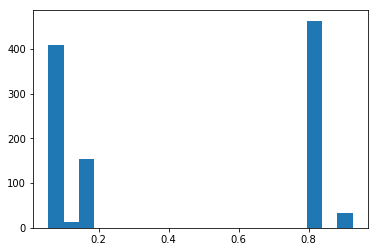

In [42]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [43]:
L_dev = BD_labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [44]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train_BD, train_marginals)

Saved 1072 marginals
CPU times: user 656 ms, sys: 4.75 ms, total: 661 ms
Wall time: 660 ms


In [45]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [46]:
train_cands = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 0).order_by(BiomarkerDrug.id).all()
dev_cands   = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 1).order_by(BiomarkerDrug.id).all()
test_cands  = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 1).order_by(BiomarkerDrug.id).all()

In [47]:
from snorkel.annotations import load_gold_labels
load_external_labels(session, BiomarkerDrug, 'Biomarker', 'Drug', 'articles/drug_gold_labels.tsv', dev_cands, annotator_name='gold')
load_external_labels(session, BiomarkerDrug, 'Biomarker', 'Drug', 'articles/drug_gold_labels.tsv', test_cands, annotator_name='gold')

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=1)




AnnotatorLabels created: 0
AnnotatorLabels created: 0
AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [48]:
print len(train_cands)
print len(dev_cands)

1072
270


In [49]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=1072  #epochs=10  batch size=256
[reRNN] Epoch 0 (1.43s)	Average loss=0.688340	Dev F1=0.00
[reRNN] Epoch 1 (2.97s)	Average loss=0.655354	Dev F1=13.11
[reRNN] Epoch 2 (4.42s)	Average loss=0.596789	Dev F1=12.90
[reRNN] Epoch 3 (5.87s)	Average loss=0.592702	Dev F1=7.87
[reRNN] Epoch 4 (7.33s)	Average loss=0.590346	Dev F1=12.99
[reRNN] Epoch 5 (8.79s)	Average loss=0.550699	Dev F1=14.29
[reRNN] Epoch 6 (10.24s)	Average loss=0.541445	Dev F1=7.79
[reRNN] Epoch 7 (11.68s)	Average loss=0.513877	Dev F1=10.26
[reRNN] Epoch 8 (13.14s)	Average loss=0.482638	Dev F1=11.70
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (15.83s)	Average loss=0.456173	Dev F1=8.93
[reRNN] Training done (15.96s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>


In [50]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.065, Recall: 0.625, F1 Score: 0.117


In [51]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.625
Neg. class accuracy: 0.429
Precision            0.0645
Recall               0.625
F1                   0.117
----------------------------------------
TP: 10 | FP: 145 | TN: 109 | FN: 6



In [52]:
lstm.save_marginals(session, test_cands)

Saved 270 marginals


In [53]:
predictions = lstm.predictions(train_cands)

In [54]:
i = 0
for prediction in predictions: 
    if(prediction == 1):
        i+=1
print i

557


In [55]:
i = 0
while( i< len(train_cands)):
    print("Candidate: {}. Prediction: {}").format(train_cands[i], predictions[i])
    i += 1

Candidate: BiomarkerDrug(Span("RNA", sentence=11014, chars=[57,59], words=[8,8]), Span("cystatin", sentence=11014, chars=[2,9], words=[1,1])). Prediction: 1
Candidate: BiomarkerDrug(Span("p38", sentence=8887, chars=[284,286], words=[52,52]), Span("insulin", sentence=8887, chars=[198,204], words=[32,32])). Prediction: -1
Candidate: BiomarkerDrug(Span("p38", sentence=8887, chars=[284,286], words=[52,52]), Span("metformin", sentence=8887, chars=[34,42], words=[7,7])). Prediction: -1
Candidate: BiomarkerDrug(Span("p38", sentence=8887, chars=[284,286], words=[52,52]), Span("rapamycin", sentence=8887, chars=[187,195], words=[30,30])). Prediction: -1
Candidate: BiomarkerDrug(Span("MAPK", sentence=8887, chars=[288,291], words=[53,53]), Span("insulin", sentence=8887, chars=[198,204], words=[32,32])). Prediction: -1
Candidate: BiomarkerDrug(Span("MAPK", sentence=8887, chars=[288,291], words=[53,53]), Span("metformin", sentence=8887, chars=[34,42], words=[7,7])). Prediction: -1
Candidate: Biomark

Candidate: BiomarkerDrug(Span("HNHA", sentence=7865, chars=[21,24], words=[4,4]), Span("sorafenib", sentence=7865, chars=[30,38], words=[6,6])). Prediction: 1
Candidate: BiomarkerDrug(Span("DNA", sentence=7865, chars=[208,210], words=[34,34]), Span("sorafenib", sentence=7865, chars=[30,38], words=[6,6])). Prediction: -1
Candidate: BiomarkerDrug(Span("ATC", sentence=7865, chars=[84,86], words=[12,12]), Span("sorafenib", sentence=7865, chars=[30,38], words=[6,6])). Prediction: 1
Candidate: BiomarkerDrug(Span("HNHA", sentence=7866, chars=[0,3], words=[0,0]), Span("sorafenib", sentence=7866, chars=[9,17], words=[2,2])). Prediction: 1
Candidate: BiomarkerDrug(Span("ATC", sentence=7866, chars=[68,70], words=[11,11]), Span("sorafenib", sentence=7866, chars=[9,17], words=[2,2])). Prediction: 1
Candidate: BiomarkerDrug(Span("HNHA", sentence=7867, chars=[31,34], words=[5,5]), Span("sorafenib", sentence=7867, chars=[40,48], words=[7,7])). Prediction: 1
Candidate: BiomarkerDrug(Span("ATC", sentenc

In [56]:
lstm.save("drugs")

[reRNN] Model saved as <drugs>
